## ITS with CausalImpact model

Interrupted time series analysis with causal impact package. An intervention here is everytime the insulin is non zero, the window size for the data impact is 30 mins either side (can be tuned)


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causalimpact import CausalImpact
import warnings
import statsmodels.formula.api as smf


In [14]:
warnings.filterwarnings("ignore", message="DataFrame.fillna with 'method' is deprecated", category=FutureWarning)
warnings.filterwarnings("ignore", message="DataFrame.applymap has been deprecated", category=FutureWarning)
warnings.filterwarnings("ignore", message="Series.__getitem__ treating keys as positions is deprecated", category=FutureWarning)
warnings.filterwarnings("ignore", message="No frequency information was provided", category=pd.errors.DtypeWarning)
warnings.filterwarnings("ignore", message="No frequency information was provided", category=UserWarning)
warnings.filterwarnings("ignore", message="Keyword arguments have been passed to the optimizer", category=FutureWarning)
warnings.filterwarnings("ignore", message="Unknown keyword arguments: dict_keys", category=FutureWarning)

In [15]:
data = pd.read_csv("../../synthetic_data/data/ml_dataset.csv", index_col=0)
data.index = pd.to_datetime(data.index)

print("Data Shape:", data.shape)
print("Date Range:", data.index.min(), "to", data.index.max())
print("Columns in dataset:", data.columns.tolist())

Data Shape: (25920, 13)
Date Range: 2024-01-01 00:00:00 to 2024-03-30 23:55:00
Columns in dataset: ['glucose', 'hour', 'day_of_week', 'carbs', 'insulin', 'exercise', 'stress', 'active_insulin', 'carb_impact', 'meal_insulin_delay', 'is_weekend', 'time_since_last_meal', 'time_since_last_insulin']


In [16]:
all_events = data.index[data['insulin'] > 0]
filtered_events = []
last_event = None

for event in all_events:
    if last_event is None or (event - last_event).total_seconds() >= 3600:
        filtered_events.append(event)
        last_event = event

print(f"\nFound {len(filtered_events)} filtered intervention times")


Found 270 filtered intervention times


In [17]:
filtered_events = filtered_events[:10]

summary_list = []

if len(filtered_events) == 0:
    print("No interventions found.")
else:
    for event_idx, event in enumerate(filtered_events):
        print(f"\n{'='*50}")
        print(f"Processing event {event_idx+1}/{len(filtered_events)} at {event}")
        
        # Define the window around the event
        window_start = event - pd.Timedelta("45min")
        window_end = event + pd.Timedelta("30min")
        
        # Extract window data with consistent resampling
        try:
            window_data = data.loc[window_start:window_end].copy()
            
            # Forward fill missing values from resampling
            window_data = window_data.fillna(method='ffill')
                
            print(f"Window data shape: {window_data.shape}")
            
            # Define pre/post periods that align with actual data points
            # Find the closest data point to the event time
            closest_pre = window_data.index[window_data.index <= event].max()
            closest_post = window_data.index[window_data.index > event].min()
            
            if pd.isna(closest_pre) or pd.isna(closest_post):
                print(f"Skipping event at {event} - cannot establish pre/post boundaries")
                continue
                
            pre_period = [window_data.index.min(), closest_pre]
            post_period = [closest_post, window_data.index.max()]
            
            # Clean data by handling missing and infinite values
            ci_data = window_data.copy()
            ci_data = ci_data.replace([np.inf, -np.inf], np.nan)
            ci_data = ci_data.dropna()
                
            print(f"Pre-period: {pre_period[0]} to {pre_period[1]}")
            print(f"Post-period: {post_period[0]} to {post_period[1]}")
            print(f"Data range: {ci_data.index.min()} to {ci_data.index.max()}")
            
            # Run the CausalImpact analysis with better error handling
            try:
                # Create full diagnostic plot to verify the data
                plt.figure(figsize=(12, 6))
                plt.subplot(211)
                plt.plot(ci_data.index, ci_data['glucose'], 'b-', label='Glucose')
                plt.axvline(x=event, color='r', linestyle='--', label='Insulin')
                plt.title(f'Glucose and Insulin Data for Event at {event}')
                plt.legend()
                
                plt.subplot(212)
                for col in ci_data.columns:
                    if col != 'glucose' and col != 'insulin':
                        plt.plot(ci_data.index, ci_data[col], label=col)
                plt.axvline(x=event, color='r', linestyle='--')
                plt.legend(loc='best')
                plt.tight_layout()
                plt.savefig(f"data_visual/event_{event_idx}_data.png")
                plt.close()
                
                # Actual CausalImpact analysis
                impact = CausalImpact(ci_data, pre_period, post_period, prior_level_sd=None)
                
                # Extract summary information
                post_inferences = impact.inferences.loc[impact.inferences.index >= post_period[0]]
                avg_effect = post_inferences['point_effects'].mean()
                cum_effect = post_inferences['post_cum_effects'].iloc[-1]
                
                # Save summary plot
                impact.plot()
                plt.tight_layout()
                plt.savefig(f"data_causal/event_{event_idx}_impact.png")
                plt.close()
                
                # Add to summary
                summary_list.append({
                    'event_time': event,
                    'window_start': window_start,
                    'window_end': window_end,
                    'insulin_dose': window_data['insulin'].sum(),
                    'avg_effect': avg_effect,
                    'cum_effect': cum_effect,
                    'pre_points': sum(window_data.index <= closest_pre),
                    'post_points': sum(window_data.index >= closest_post)
                })
                
                print(f"Success: CausalImpact analysis completed for event at {event}")
                print(f"Average effect: {avg_effect:.2f}, Cumulative effect: {cum_effect:.2f}")
                
            except Exception as e:
                print(f"Error running CausalImpact for event at {event}:")
                print(f"Error type: {type(e).__name__}")
                print(f"Error message: {str(e)}")
                
                # Additional diagnostic information
                print(f"Data shape: {ci_data.shape}")
                print(f"Column dtypes: {ci_data.dtypes}")
                print(f"Index type: {type(ci_data.index)}")
                
        except Exception as e:
            print(f"Error processing window data for event at {event}:")
            print(f"Error type: {type(e).__name__}")
            print(f"Error message: {str(e)}")



Processing event 1/10 at 2024-01-01 07:30:00
Window data shape: (16, 13)
Pre-period: 2024-01-01 06:45:00 to 2024-01-01 07:30:00
Post-period: 2024-01-01 07:35:00 to 2024-01-01 08:00:00
Data range: 2024-01-01 06:45:00 to 2024-01-01 08:00:00
Error running CausalImpact for event at 2024-01-01 07:30:00:
Error type: MissingDataError
Error message: exog contains inf or nans
Data shape: (16, 13)
Column dtypes: glucose                      int64
hour                         int64
day_of_week                  int64
carbs                        int64
insulin                    float64
exercise                     int64
stress                     float64
active_insulin             float64
carb_impact                float64
meal_insulin_delay           int64
is_weekend                   int64
time_since_last_meal         int64
time_since_last_insulin      int64
dtype: object
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>

Processing event 2/10 at 2024-01-01 12:05:00
Window data 

In [18]:
print(ci_data.isnull().sum())
print(np.isinf(ci_data).sum())

glucose                    0
hour                       0
day_of_week                0
carbs                      0
insulin                    0
exercise                   0
stress                     0
active_insulin             0
carb_impact                0
meal_insulin_delay         0
is_weekend                 0
time_since_last_meal       0
time_since_last_insulin    0
dtype: int64
glucose                    0
hour                       0
day_of_week                0
carbs                      0
insulin                    0
exercise                   0
stress                     0
active_insulin             0
carb_impact                0
meal_insulin_delay         0
is_weekend                 0
time_since_last_meal       0
time_since_last_insulin    0
dtype: int64


In [19]:
if summary_list:
    summary_df = pd.DataFrame(summary_list)
    print("\nCombined Summary of All Runs:")
    print(summary_df)

## ITS with StatModel

ITS Regression Summary for event at 2024-01-01 07:30:00:

                            OLS Regression Results                            
Dep. Variable:                glucose   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     104.3
Date:                Tue, 25 Feb 2025   Prob (F-statistic):           2.62e-07
Time:                        15:02:09   Log-Likelihood:                -26.013
No. Observations:                  13   AIC:                             60.03
Df Residuals:                       9   BIC:                             62.29
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

/Users/jonathangong/Code/Repositories/causal_modeling/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)


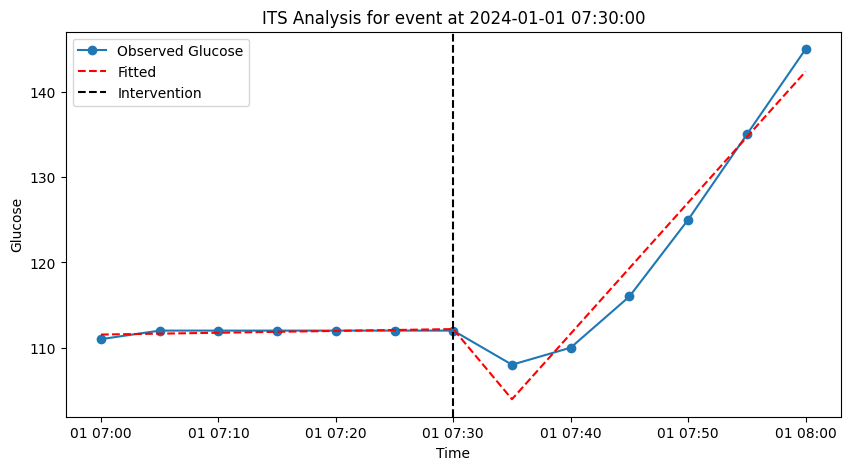

ITS Regression Summary for event at 2024-01-01 12:05:00:

                            OLS Regression Results                            
Dep. Variable:                glucose   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     5969.
Date:                Tue, 25 Feb 2025   Prob (F-statistic):           3.69e-15
Time:                        15:02:09   Log-Likelihood:                -1.4731
No. Observations:                  13   AIC:                             10.95
Df Residuals:                       9   BIC:                             13.21
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

/Users/jonathangong/Code/Repositories/causal_modeling/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)


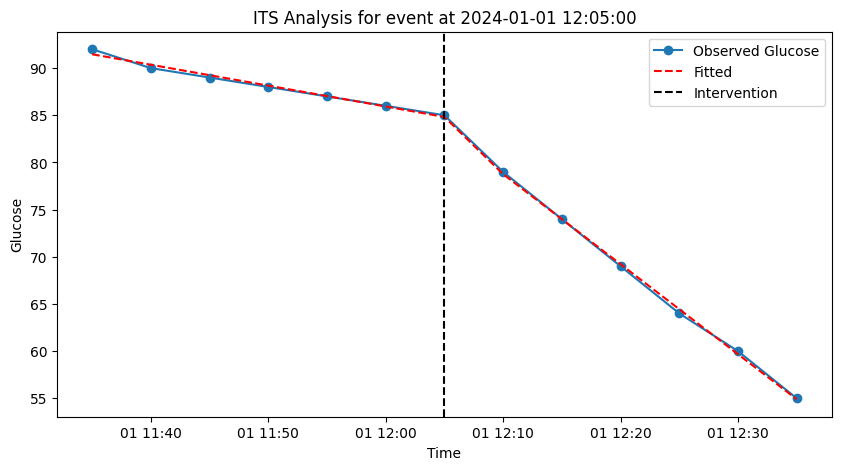

ITS Regression Summary for event at 2024-01-01 19:00:00:

                            OLS Regression Results                            
Dep. Variable:                glucose   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     4.564
Date:                Tue, 25 Feb 2025   Prob (F-statistic):             0.0331
Time:                        15:02:09   Log-Likelihood:                -33.633
No. Observations:                  13   AIC:                             75.27
Df Residuals:                       9   BIC:                             77.53
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

/Users/jonathangong/Code/Repositories/causal_modeling/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)


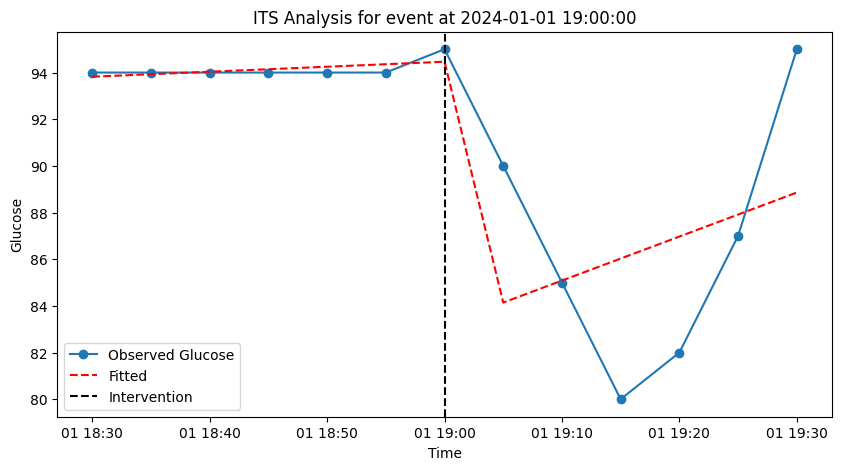

ITS Regression Summary for event at 2024-01-02 07:40:00:

                            OLS Regression Results                            
Dep. Variable:                glucose   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     7.141
Date:                Tue, 25 Feb 2025   Prob (F-statistic):            0.00938
Time:                        15:02:09   Log-Likelihood:                -31.687
No. Observations:                  13   AIC:                             71.37
Df Residuals:                       9   BIC:                             73.63
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

/Users/jonathangong/Code/Repositories/causal_modeling/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)


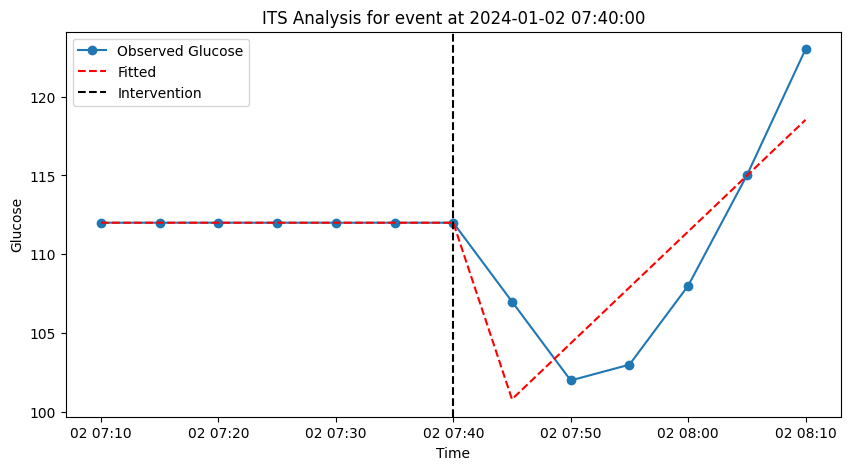

ITS Regression Summary for event at 2024-01-02 12:45:00:

                            OLS Regression Results                            
Dep. Variable:                glucose   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     160.5
Date:                Tue, 25 Feb 2025   Prob (F-statistic):           3.94e-08
Time:                        15:02:09   Log-Likelihood:                -19.972
No. Observations:                  13   AIC:                             47.94
Df Residuals:                       9   BIC:                             50.20
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

/Users/jonathangong/Code/Repositories/causal_modeling/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)


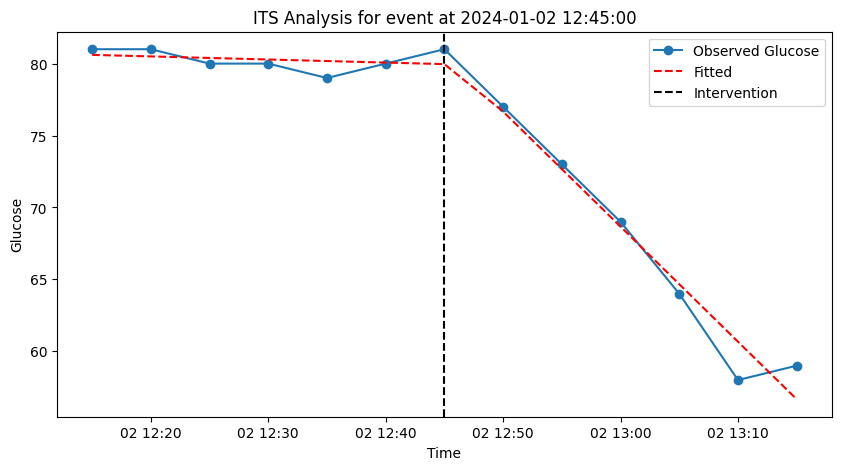

ITS Regression Summary for event at 2024-01-02 18:25:00:

                            OLS Regression Results                            
Dep. Variable:                glucose   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     15.97
Date:                Tue, 25 Feb 2025   Prob (F-statistic):           0.000601
Time:                        15:02:09   Log-Likelihood:                -28.184
No. Observations:                  13   AIC:                             64.37
Df Residuals:                       9   BIC:                             66.63
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

/Users/jonathangong/Code/Repositories/causal_modeling/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)


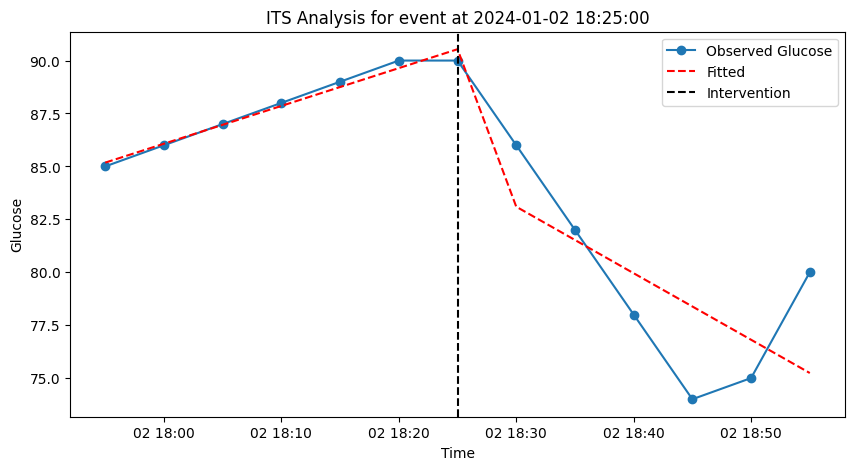

ITS Regression Summary for event at 2024-01-03 07:40:00:

                            OLS Regression Results                            
Dep. Variable:                glucose   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     6.353
Date:                Tue, 25 Feb 2025   Prob (F-statistic):             0.0133
Time:                        15:02:09   Log-Likelihood:                -32.422
No. Observations:                  13   AIC:                             72.84
Df Residuals:                       9   BIC:                             75.10
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

/Users/jonathangong/Code/Repositories/causal_modeling/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)


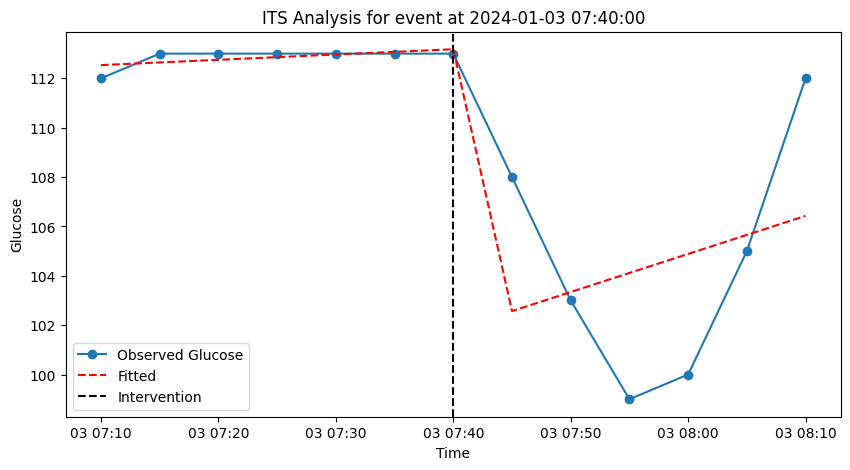

ITS Regression Summary for event at 2024-01-03 12:40:00:

                            OLS Regression Results                            
Dep. Variable:                glucose   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     10.14
Date:                Tue, 25 Feb 2025   Prob (F-statistic):            0.00303
Time:                        15:02:09   Log-Likelihood:                -33.752
No. Observations:                  13   AIC:                             75.50
Df Residuals:                       9   BIC:                             77.76
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

/Users/jonathangong/Code/Repositories/causal_modeling/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)


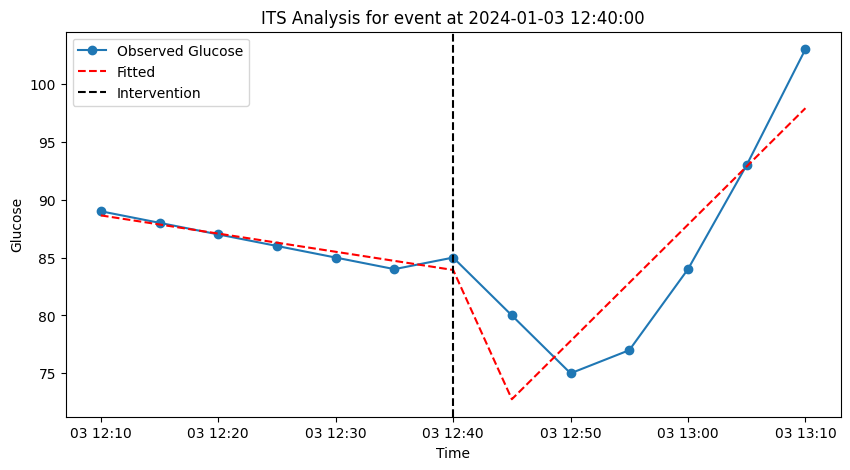

ITS Regression Summary for event at 2024-01-03 18:55:00:

                            OLS Regression Results                            
Dep. Variable:                glucose   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     24.16
Date:                Tue, 25 Feb 2025   Prob (F-statistic):           0.000122
Time:                        15:02:09   Log-Likelihood:                -29.800
No. Observations:                  13   AIC:                             67.60
Df Residuals:                       9   BIC:                             69.86
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

/Users/jonathangong/Code/Repositories/causal_modeling/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)


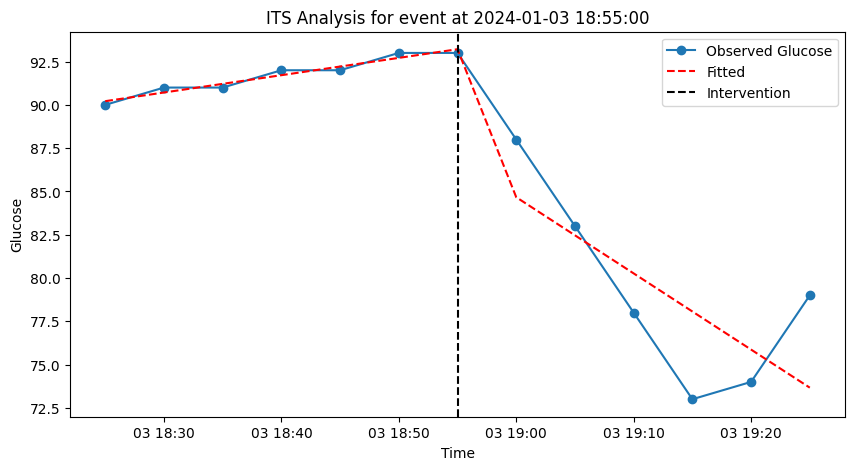

ITS Regression Summary for event at 2024-01-04 07:30:00:

                            OLS Regression Results                            
Dep. Variable:                glucose   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     32.27
Date:                Tue, 25 Feb 2025   Prob (F-statistic):           3.81e-05
Time:                        15:02:10   Log-Likelihood:                -28.844
No. Observations:                  13   AIC:                             65.69
Df Residuals:                       9   BIC:                             67.95
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

/Users/jonathangong/Code/Repositories/causal_modeling/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)


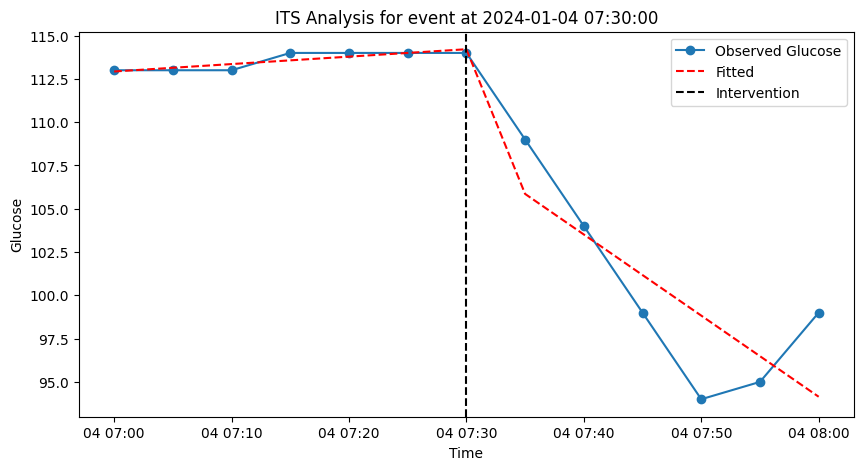


Combined Summary of All Runs:
           event_time        window_start          window_end  insulin_dose  \
0 2024-01-01 07:30:00 2024-01-01 07:00:00 2024-01-01 08:00:00           4.9   
1 2024-01-01 12:05:00 2024-01-01 11:35:00 2024-01-01 12:35:00           5.6   
2 2024-01-01 19:00:00 2024-01-01 18:30:00 2024-01-01 19:30:00           6.1   
3 2024-01-02 07:40:00 2024-01-02 07:10:00 2024-01-02 08:10:00           6.1   
4 2024-01-02 12:45:00 2024-01-02 12:15:00 2024-01-02 13:15:00           6.5   
5 2024-01-02 18:25:00 2024-01-02 17:55:00 2024-01-02 18:55:00           6.5   
6 2024-01-03 07:40:00 2024-01-03 07:10:00 2024-01-03 08:10:00           5.4   
7 2024-01-03 12:40:00 2024-01-03 12:10:00 2024-01-03 13:10:00           6.6   
8 2024-01-03 18:55:00 2024-01-03 18:25:00 2024-01-03 19:25:00           7.5   
9 2024-01-04 07:30:00 2024-01-04 07:00:00 2024-01-04 08:00:00           5.4   

   level_change  slope_change  
0    -61.383333      1.515714  
1     20.697619     -0.732857  
2  

In [20]:
summary_list = []

if len(filtered_events) == 0:
    print("No interventions found.")
else:
    for event in filtered_events:
        # Define a one-hour window: 30 minutes before to 30 minutes after the event.
        window_start = event - pd.Timedelta("30min")
        window_end   = event + pd.Timedelta("30min")
        
        # Extract window data and resample to 5-minute intervals.
        window_data = data.loc[window_start:window_end].resample('5min').ffill()
        if window_data.empty or len(window_data) < 10:
            print(f"Skipping event at {event} due to insufficient data in the window.")
            continue
        
        # Reset index so that time becomes a column for regression.
        window_data = window_data.reset_index()
        
        # Create a 'time' variable (in minutes since the start of the window)
        window_data['time'] = (window_data['index'] - window_data['index'].min()).dt.total_seconds() / 60.0
        
        # Create a dummy variable indicating the post-intervention period
        window_data['post'] = (window_data['index'] > event).astype(int)
        
        # Interaction term: time * post to allow the slope to change after intervention.
        window_data['time_post'] = window_data['time'] * window_data['post']
        
        # Ensure that the outcome variable exists.
        # Replace 'glucose' with your actual outcome variable name.
        if 'glucose' not in window_data.columns:
            print("Outcome variable 'glucose' not found in data; please adjust accordingly.")
            break
        
        # Fit the ITS regression model:
        #   outcome ~ time + post + time_post
        model = smf.ols("glucose ~ time + post + time_post", data=window_data).fit()
        print(f"ITS Regression Summary for event at {event}:\n")
        print(model.summary())
        
        # Calculate estimated immediate level change and change in slope:
        level_change = model.params['post']
        slope_change = model.params['time_post']
        
        summary_list.append({
            'event_time': event,
            'window_start': window_start,
            'window_end': window_end,
            'insulin_dose': window_data['insulin'].sum(),
            'level_change': level_change,
            'slope_change': slope_change
        })
        
        # (Optional) Plot the data and fitted regression lines.
        plt.figure(figsize=(10, 5))
        plt.plot(window_data['index'], window_data['glucose'], 'o-', label='Observed Glucose')
        # Predicted values
        window_data['fitted'] = model.fittedvalues
        plt.plot(window_data['index'], window_data['fitted'], 'r--', label='Fitted')
        plt.axvline(x=event, color='k', linestyle='--', label='Intervention')
        plt.xlabel('Time')
        plt.ylabel('Glucose')
        plt.title(f'ITS Analysis for event at {event}')
        plt.legend()
        plt.show()

summary_df = pd.DataFrame(summary_list)
print("\nCombined Summary of All Runs:")
print(summary_df)